In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
df = pd.read_csv('datasets/cleaned_online_sex_work.csv')
df.head()

,User_ID,Female,Age,Location,Verification,Heterosexual,Homosexual,bicurious,bisexual,Dominant,...,Member_since_month,Member_since_day,Number_of_Comments_in_public_forum,Time_spent_chating_H:M,Number_of_advertisments_posted,Number_of_offline_meetings_attended,Number of Friends,Profile_pictures,Friends_ID_list,Risk
0,10386,False,34.6,A,False,0,1,0,0,0,...,9,17,32,2,0,0,1,0,18260,0.0
1,14,False,32.2,J,False,1,0,0,0,1,...,11,1,710,225,9,0,7,0,"11778,32024,43768,23969,27318,45884,31277",0.0
2,16721,False,33.6,K,False,1,0,0,0,1,...,4,1,25,135,1,1,3,45,"19805,21721,19802",0.0
3,16957,False,34.0,H,False,1,0,0,0,1,...,4,8,107,21562,1,0,12,1,"40847,38183,9507,42259,5807,28118,24848,37170,...",0.0
4,17125,False,39.5,B,False,1,0,0,0,1,...,4,14,600,21,0,6,35,8,"1320,35739,34231,19097,20197,18069,12330,43342...",0.0


In [3]:
truth_map = {True: 1, False: 0}

df['Female'] = df['Female'].map(truth_map)
df['Verification'] = df['Verification'].map(truth_map)


In [4]:
#too many categories, so we take the top 10 and make dummies
top_10 = df['Location'].value_counts().head(10).index.to_list()

def dummies(d, var, top10):
    for label in top10:
        d[var+'_'+label] = np.where(df[var] == label, 1, 0)

dummies(df, 'Location', top_10)
df.drop('Location', axis = 1, inplace = True)

In [5]:
df.drop('User_ID', axis = 1, inplace=True)

In [8]:
df.drop('Friends_ID_list',axis = 1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Female                               28831 non-null  int64  
 1   Age                                  28831 non-null  float64
 2   Verification                         28831 non-null  int64  
 3   Heterosexual                         28831 non-null  int64  
 4   Homosexual                           28831 non-null  int64  
 5   bicurious                            28831 non-null  int64  
 6   bisexual                             28831 non-null  int64  
 7   Dominant                             28831 non-null  int64  
 8   Submisive                            28831 non-null  int64  
 9   Switch                               28831 non-null  int64  
 10  Men                                  28831 non-null  int64  
 11  Men_and_Women               

In [14]:
df.isna().sum()

Female                                     0
Age                                        0
Verification                               0
Heterosexual                               0
Homosexual                                 0
bicurious                                  0
bisexual                                   0
Dominant                                   0
Submisive                                  0
Switch                                     0
Men                                        0
Men_and_Women                              0
Nobody                                     0
Nobody_but_maybe                           0
Women                                      0
Points_Rank                                0
Last_login                                 0
Member_since_year                          0
Member_since_month                         0
Member_since_day                           0
Number_of_Comments_in_public_forum         0
Time_spent_chating_H:M                     0
Number_of_

In [32]:
def calc_loss(actual, predicted):
    bce = BinaryCrossentropy(from_logits=True)
    return bce(actual, predicted).numpy()

In [33]:
param_grid = ParameterGrid(
    {
        'hidden_layers': [0,1,2],
        'neurons': [40,50,60],
        'epochs': [300, 100, 200]
    }
)

In [34]:
def create_model(params):
    model = Sequential()
    model.add(Dense(36, activation='relu'))
    for i in range(params['hidden_layers']):
        model.add(Dense(params['neurons'], activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [103]:
#function to tune the model

def tune_hyperparameters(param_grid, X_train, y_train):
    parameters = pd.DataFrame(columns=["log_loss", "params"])
    for parameter_set in param_grid:
        model = create_model(parameter_set)
        model.fit(X_train, y_train, epochs = parameter_set['epochs'], verbose=0)
        preds = model.predict(X_train, verbose=0)
        loss = calc_loss(y_train, preds)
        parameters = pd.concat([pd.DataFrame({"log_loss":loss, "params": parameter_set}), parameters], axis=0)
    min_loss = parameters['log_loss'].sort_values(ascending=False)[0]
    best_params = parameters[parameters['log_loss'] == min_loss]
    return {
    'epochs': best_params.loc['epochs']['params'],
    'hidden_layers': best_params.loc['hidden_layers']['params'],
    'neurons': best_params.loc['neurons']['params']
    }   
    

In [116]:
labelled = df.dropna()

X = labelled.drop('Risk', axis = 1)
y = labelled['Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [105]:
y_train.value_counts()

0.0    42
1.0    30
Name: Risk, dtype: int64

In [106]:
X_train.shape

(72, 36)

In [107]:
model = Sequential()
model.add(Dense(36, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [108]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)

Epoch 1/200
3/3 [==============================] - 1s 89ms/step - loss: 147.0985 - accuracy: 0.5833 - val_loss: 287.1133 - val_accuracy: 0.8333
Epoch 2/200
3/3 [==============================] - 0s 13ms/step - loss: 116.7722 - accuracy: 0.5833 - val_loss: 242.3508 - val_accuracy: 0.8333
Epoch 3/200
3/3 [==============================] - 0s 13ms/step - loss: 81.3933 - accuracy: 0.5833 - val_loss: 207.4496 - val_accuracy: 0.8889
Epoch 4/200
3/3 [==============================] - 0s 13ms/step - loss: 60.1858 - accuracy: 0.5417 - val_loss: 188.4504 - val_accuracy: 0.3333
Epoch 5/200
3/3 [==============================] - 0s 13ms/step - loss: 52.3763 - accuracy: 0.5833 - val_loss: 181.0711 - val_accuracy: 0.2778
Epoch 6/200
3/3 [==============================] - 0s 14ms/step - loss: 52.2966 - accuracy: 0.5278 - val_loss: 164.4889 - val_accuracy: 0.2778
Epoch 7/200
3/3 [==============================] - 0s 14ms/step - loss: 47.0234 - accuracy: 0.5278 - val_loss: 137.7018 - val_accuracy: 0.27

<AxesSubplot:>

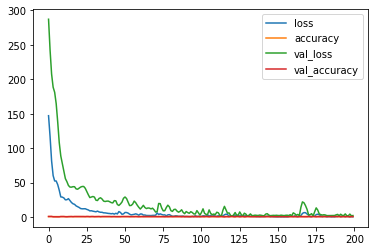

In [109]:
pd.DataFrame(model.history.history).plot()

In [110]:
y_train.shape

(72,)

In [117]:
y_train = y_train.values.reshape(y_train.shape[0], 1)

best_params = tune_hyperparameters(param_grid, X_train, y_train)

In [118]:
best_params

{'epochs': 200, 'hidden_layers': 2, 'neurons': 50}

In [119]:
model = create_model(best_params)

model.fit(X_train, y_train, epochs = best_params['epochs'], validation_data = (X_test, y_test))

Epoch 1/200
3/3 [==============================] - 1s 119ms/step - loss: 480.8309 - accuracy: 0.4167 - val_loss: 49.9131 - val_accuracy: 0.1667
Epoch 2/200
3/3 [==============================] - 0s 15ms/step - loss: 43.6221 - accuracy: 0.4583 - val_loss: 170.8438 - val_accuracy: 0.8333
Epoch 3/200
3/3 [==============================] - 0s 19ms/step - loss: 84.2412 - accuracy: 0.5972 - val_loss: 246.4852 - val_accuracy: 0.8333
Epoch 4/200
3/3 [==============================] - 0s 18ms/step - loss: 106.7063 - accuracy: 0.5833 - val_loss: 264.2280 - val_accuracy: 0.8333
Epoch 5/200
3/3 [==============================] - 0s 19ms/step - loss: 104.3049 - accuracy: 0.5833 - val_loss: 258.5974 - val_accuracy: 0.8333
Epoch 6/200
3/3 [==============================] - 0s 20ms/step - loss: 84.6007 - accuracy: 0.5972 - val_loss: 243.6596 - val_accuracy: 0.5556
Epoch 7/200
3/3 [==============================] - 0s 19ms/step - loss: 74.2840 - accuracy: 0.5972 - val_loss: 237.1503 - val_accuracy: 0.3

<AxesSubplot:>

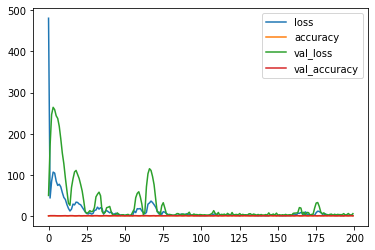

In [120]:
pd.DataFrame(model.history.history).plot()

In [124]:
preds = model.predict(X_test)
new = []
for i in preds:
    if i > 0.5:
        new.append(1)
    else:
        new.append(0)

print(classification_report(y_test, new))

1/1 [==============================] - 0s 44ms/step
              precision    recall  f1-score   support

         0.0       0.80      0.27      0.40        15
         1.0       0.15      0.67      0.25         3

    accuracy                           0.33        18
   macro avg       0.48      0.47      0.33        18
weighted avg       0.69      0.33      0.38        18

